In [1]:
# !pip install ftfy 
# !pip install transformers diffusers==0.2.4 # For now specific version needed as update broke something
%reload_ext autoreload
%autoreload 2

from tqdm import tqdm 
import torch
from torch import autocast, inference_mode
from wrapper import StableDifussionWrapper, image_grid


self = StableDifussionWrapper(scheduler_type = "lms")


100%|██████████| 2/2 [00:14<00:00,  7.33s/it]


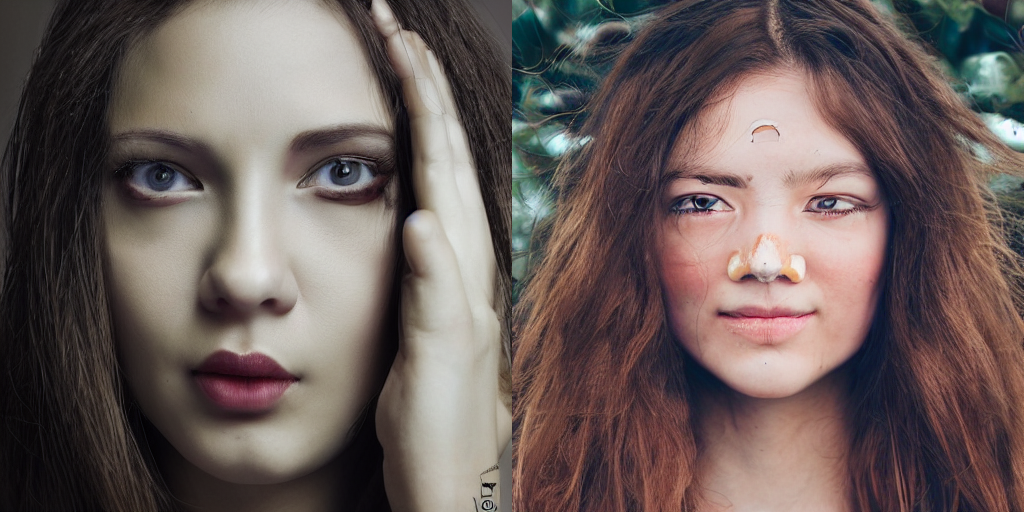

In [2]:

# Warning: This wrapper does not have a safety filter nor adds watermark to images. Be ethical!

prompt = "face portrait, photography, full face"
self.set_scheduler(scheduler_type="lms")
all_imgs = self.generate_images(prompt,
                        n = 2,
                        seed=2, 
                        num_inference_steps=50, 
                        guidance_scale=3)
grid = image_grid(all_imgs, rows=1, cols=2)
# grid.save("bahai-day.png")
grid

sigma start tensor(14.6147, dtype=torch.float64)
latents tensor(1876.5876, device='cuda:0')
text_embeddings tensor(356.9981, device='cuda:0')


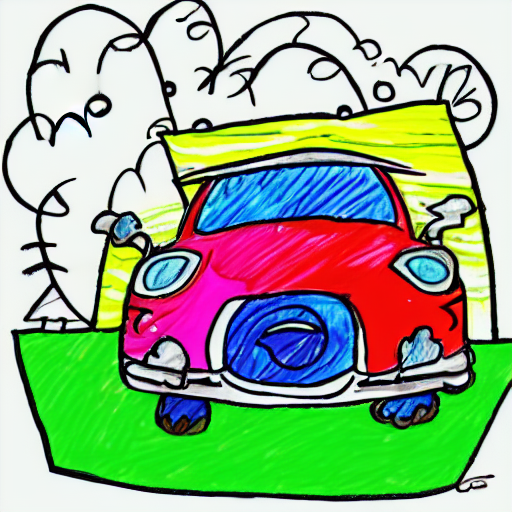

In [113]:
prompt = "a car, poorly draw by a child, colorfull"

zT = self.random_latents(seed = 87)

z0 = self.diffusion_loop(
        prompt=prompt,
        latents=zT,
        start_step=0,
        seed=None,
        num_inference_steps=20,
        guidance_scale=7.5)
x0 = self.decode(z0)
image_grid(x0)

In [4]:
with torch.no_grad():
    latent_dists = self.vae.encode(x0)
    latent_samples = latent_dists.sample()
    latent_samples *= 0.18215

sigma start tensor(6.6780, dtype=torch.float64)
latents tensor(851.7948, device='cuda:0')
text_embeddings tensor(357.5779, device='cuda:0')


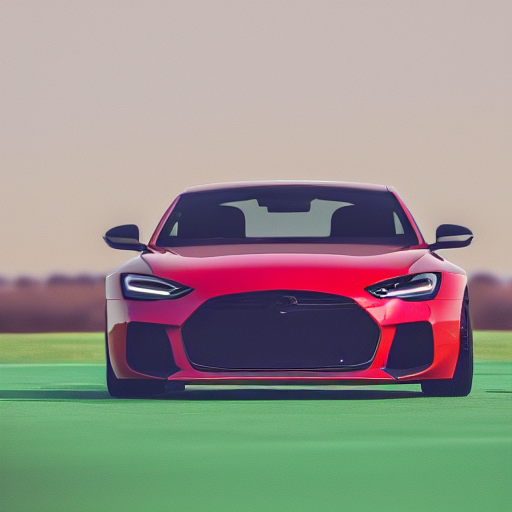

In [121]:
self.set_scheduler(scheduler_type="lms")

prompt_trans = "A photo of a car, photography, 4K, HD"
z0_new = self.diffusion_loop(
        prompt=prompt_trans,
        latents=z0, #latent_samples,
        start_step=7,
        seed=2,
        num_inference_steps=50,
        guidance_scale=7.5,
        debugging_offset = 0
        )
x0_new = self.decode(z0_new)
image_grid(x0_new)

### Debugging lsm forward 

In [123]:

# from torchvision import transforms as tfms
# from wrapper import pil_to_tensor, tensor_to_pil
# from PIL import Image

# torch_device = "cuda"
# # Using torchvision.transforms.ToTensor
# to_tensor_tfm = tfms.ToTensor()

# def pil_to_latent(input_im):
#   # Single image -> single latent in a batch (so size 1, 4, 64, 64)
#   with torch.no_grad():
#     latent = self.vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
#   return 0.18215 * latent.mode() # or .mean or .sample

# def latents_to_pil(latents):
#   # bath of latents -> list of images
#   latents = (1 / 0.18215) * latents
#   with torch.no_grad():
#     image = self.vae.decode(latents)
#   image = (image / 2 + 0.5).clamp(0, 1)
#   image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
#   images = (image * 255).round().astype("uint8")
#   pil_images = [Image.fromarray(image) for image in images]
#   return pil_images


# def subtract_images(image1,image2):
#     import numpy as np

#     # Get the image buffer as ndarray
#     buffer1  = np.asarray(image1)
#     buffer2  = np.asarray(image2)

#     # Subtract image2 from image1
#     buffer3    = buffer1 - buffer2

#     # Construct a new Image from the resultant buffer
#     differenceImage     = Image.fromarray(buffer3)
#     return differenceImage

In [124]:

# # Download a demo Image
# #!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

# # Load the image with PIL
# input_image = Image.open('macaw.jpg').resize((512, 512))

# x0 = pil_to_tensor(input_image).to(self.device)
# input_image

In [125]:
# encoded = pil_to_latent(input_image)
# encoded.shape
# decoded = latents_to_pil(encoded)[0]
# decoded

In [126]:

# z0 = self.encode(x0)
# x0_rec = self.decode(z0)
# x0_rec_pil = tensor_to_pil(x0_rec)[0]

In [127]:
# encoded = z0

In [128]:
# tokenizer = self.tokenizer
# text_encoder = self.text_encoder
# scheduler = self.scheduler
# unet = self.unet


# #@title re-generate starting from a noised version of this image
# prompt = ["A colorful dancer, nat geo photo"] #@param
# # height = 512                        # default height of Stable Diffusion
# # width = 512                         # default width of Stable Diffusion
# num_inference_steps = 50  #@param           # Number of denoising steps
# guidance_scale = 8                # Scale for classifier-free guidance
# generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
# batch_size = 1

# # Prep text 
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# with torch.no_grad():
#   text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
# max_length = text_input.input_ids.shape[-1]
# uncond_input = tokenizer(
#     [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
# )
# with torch.no_grad():
#   uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
# text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# # Prep Scheduler
# scheduler.set_timesteps(num_inference_steps)

# # Start step
# start_step = 15 #@param Explore ;)
# start_sigma = scheduler.sigmas[start_step]
# start_timestep = int(scheduler.timesteps[start_step])

# # Prep latents
# noise = torch.randn_like(z0)
# latents = scheduler.add_noise(z0, noise, start_timestep)
# latents = latents.to(torch_device)
# latents = latents * start_sigma  # << NB



# print("sigma start", self.scheduler.sigmas[start_step])
# print("latents", torch.norm(latents))
# print("text_embeddings", torch.norm(text_embeddings))
# # Loop
# with autocast("cuda"):
#   for i, t in tqdm(enumerate(scheduler.timesteps)):
#     if i >= start_step:

#       # print(i,t)
#       # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
#       latent_model_input = torch.cat([latents] * 2)
#       sigma = scheduler.sigmas[i]
#       latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

#       # predict the noise residual
#       with torch.no_grad():
#         noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

#       # perform guidance
#       noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#       noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#       # compute the previous noisy sample x_t -> x_t-1
#       latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# latents_to_pil(latents)[0]

In [129]:
# torch.manual_seed(32)
# # Start step
# start_step = 10 #@param Explore ;)
# start_sigma = scheduler.sigmas[start_step]
# start_timestep = int(scheduler.timesteps[start_step])

# # Prep latents
# noise = torch.randn_like(z0)
# latents = scheduler.add_noise(z0, noise, start_timestep)
# latents = latents.to(torch_device)
# latents = latents * start_sigma  # << NB


# # Prep text 
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# with torch.no_grad():
#   text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
# max_length = text_input.input_ids.shape[-1]
# uncond_input = tokenizer(
#     [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
# )
# with torch.no_grad():
#   uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
# text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


# print("sigma start", self.scheduler.sigmas[start_step])
# print("latents", torch.norm(latents))
# print("text_embeddings", torch.norm(text_embeddings))

In [130]:
# prompt_trans = "A colorful dancer, nat geo photo"
# text_embeddings_my = self.prep_text(prompt_trans)
# torch.norm(text_embeddings_my - text_embeddings)



In [131]:
# prompt_trans = "A colorful dancer, nat geo photo"
# z0_new = self.diffusion_loop(
#         prompt=prompt_trans,
#         latents=z0, #latent_samples,
#         start_step=10,
#         seed=32,
#         num_inference_steps=50,
#         guidance_scale=7.5,
#         debugging_offset = 0
#         )
# x0_new = self.decode(z0_new)
# image_grid(x0_new)